In [1]:
# 2群の平均値の差をベイズ推定（≒t検定）
# bayesian analytics on the difference of two means called t_test
# for AB testing on multinomial like revenue

In [2]:
# import
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import pymc as pm
import arviz as az

In [3]:
import sys
print('Python v{}'.format(sys.version))
print('Pandas v{}'.format(pd.__version__))
print('Numpy v{}'.format(np.__version__))
import matplotlib
print(f"Matplotlib v{matplotlib.__version__}")

print('PyMC v{}'.format(pm.__version__))
print('Arviz v{}'.format(az.__version__))

Python v3.11.11 | packaged by conda-forge | (main, Dec  5 2024, 14:21:42) [Clang 18.1.8 ]
Pandas v2.2.3
Numpy v1.26.4
Matplotlib v3.10.0
PyMC v5.20.1
Arviz v0.20.0


In [4]:
# read_data

x_A = [
    1.96, 2.06, 2.03, 2.11, 1.88, 1.88, 2.08, 1.93, 2.03, 2.03, 2.03, 2.08, 2.03, 2.11, 1.93    
]

In [5]:
x_B = [
    1.83, 1.93, 1.88, 1.85, 1.85, 1.91, 1.91, 1.85, 1.88, 1.91, 1.93, 1.80, 1.80, 1.85, 1.93, 
    1.85, 1.83, 1.85, 2.01, 1.85, 1.99, 1.85, 2.03, 1.90, 1.95
    
]

In [ ]:
# data_check

print(x_A)
print(x_B)
print(len(x_A))
print(len(x_B))

# print(x_A.describe())
# print(x_B.describe())

# numpy を使って統計情報を表示
print("Mean:", round(np.mean(x_A),2))
print("Median:", np.median(x_A))
print("Standard Deviation:", round(np.std(x_A),2))

print("Mean:", round(np.mean(x_B),2))
print("Median:", np.median(x_B))
print("Standard Deviation:", round(np.std(x_B),2))


[1.96, 2.06, 2.03, 2.11, 1.88, 1.88, 2.08, 1.93, 2.03, 2.03, 2.03, 2.08, 2.03, 2.11, 1.93]
[1.83, 1.93, 1.88, 1.85, 1.85, 1.91, 1.91, 1.85, 1.88, 1.91, 1.93, 1.8, 1.8, 1.85, 1.93, 1.85, 1.83, 1.85, 2.01, 1.85, 1.99, 1.85, 2.03, 1.9, 1.95]
15
25
Mean: 2.01
Median: 2.03
Standard Deviation: 0.07
Mean: 1.89
Median: 1.88
Standard Deviation: 0.06


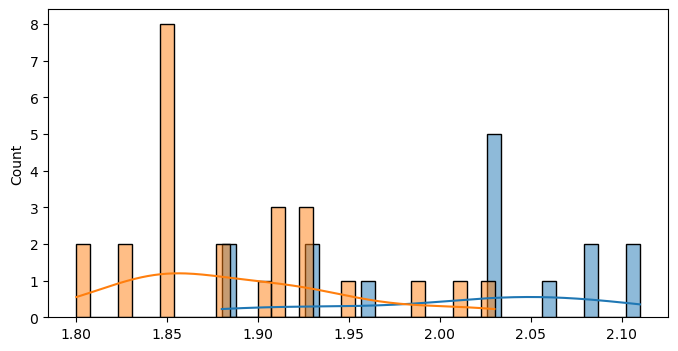

In [7]:
# histogram
plt.figure(figsize=(8,4))
sns.histplot(x_A, bins=30, kde=True)
sns.histplot(x_B, bins=30, kde=True)
plt.show()

In [8]:
# model_creation

# prior_distributions_of_mu
pooled_mean = np.r_[x_A, x_B].mean()
pooled_std = np.r_[x_A, x_B].std() * 2


# prior_distributions_of_sigma
std_low = .1
std_high = 10
# サンプリング結果が思わしくない場合には広めにとったり範囲を変えてみる
# std_low = .001
# std_high = 1000

# prior_distributions_of_nu
# ν（ニュー）自由度：[0<ν<♾️]の幅を持つ、t分布が正規分布にどれほど似ているかを表す
# νが小さいと正規分布よりも両端が厚くなり（Cauthy分布、Lorentz分布とも呼ばれる）
# νが小さい＝広くて厚い両端＝正規分布よりも平均から離れた値が生じる可能性がより高くなる＝平均の周りに値が集中しない
# νが無限大に近づく＝正規分布に近似していく

# νの事前分布は、右に1だけシフトした指数分布と置いてる
# νの値が小さい（＝両端が厚い）に高い事前確率を割り当てるのが好都合だかららしい

# 平均と標準偏差それぞれの絶対値差分と効果量についてもモデル作成


with pm.Model() as model_t:
    mu_A = pm.Normal('mu_A', mu=pooled_mean, sigma=pooled_std)
    mu_B = pm.Normal('mu_B', mu=pooled_mean, sigma=pooled_std)
    std_A = pm.Uniform('std_A', lower=std_low, upper=std_high)
    std_B = pm.Uniform('std_B', lower=std_low, upper=std_high)
    nu_minus_1 = pm.Exponential('nu_minus_1', 1/29) + 1

    obs_A = pm.StudentT('obs_A', mu=mu_A, sigma=std_A, nu=nu_minus_1, observed=x_A)
    obs_B = pm.StudentT('obs_B', mu=mu_B, sigma=std_B, nu=nu_minus_1, observed=x_B)

    mu_diff = pm.Deterministic('absolute_difference_of_means', mu_A - mu_B)
    std_diff = pm.Deterministic('absolute_difference_of_stds', std_A - std_B)
    effect_size = pm.Deterministic('effect_size', mu_diff / np.sqrt((std_A**2 + std_B**2) / 2))
    mu_diff_rr = pm.Deterministic('relative_difference_of_means', (mu_A - mu_B) / mu_B)

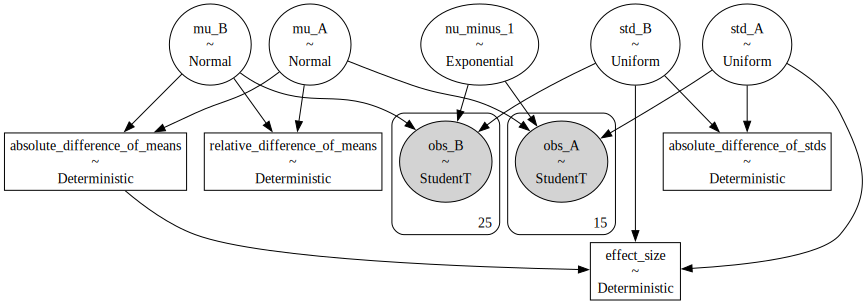

In [9]:
# モデルのグラフィカル表示
pm.model_to_graphviz(model_t)

In [10]:
# sampling
with model_t:
    start = pm.find_MAP()
    prior_t = pm.sample_prior_predictive()
    trace_t = pm.sample(tune=2000, drwas=2000, chains=4, random_seed=42, return_inferencedata=True)
    posterior_predictive_t = pm.sample_posterior_predictive(trace_t)

Output()

Sampling: [mu_A, mu_B, nu_minus_1, obs_A, obs_B, std_A, std_B]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_A, mu_B, std_A, std_B, nu_minus_1]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 2 seconds.
Sampling: [obs_A, obs_B]


Output()

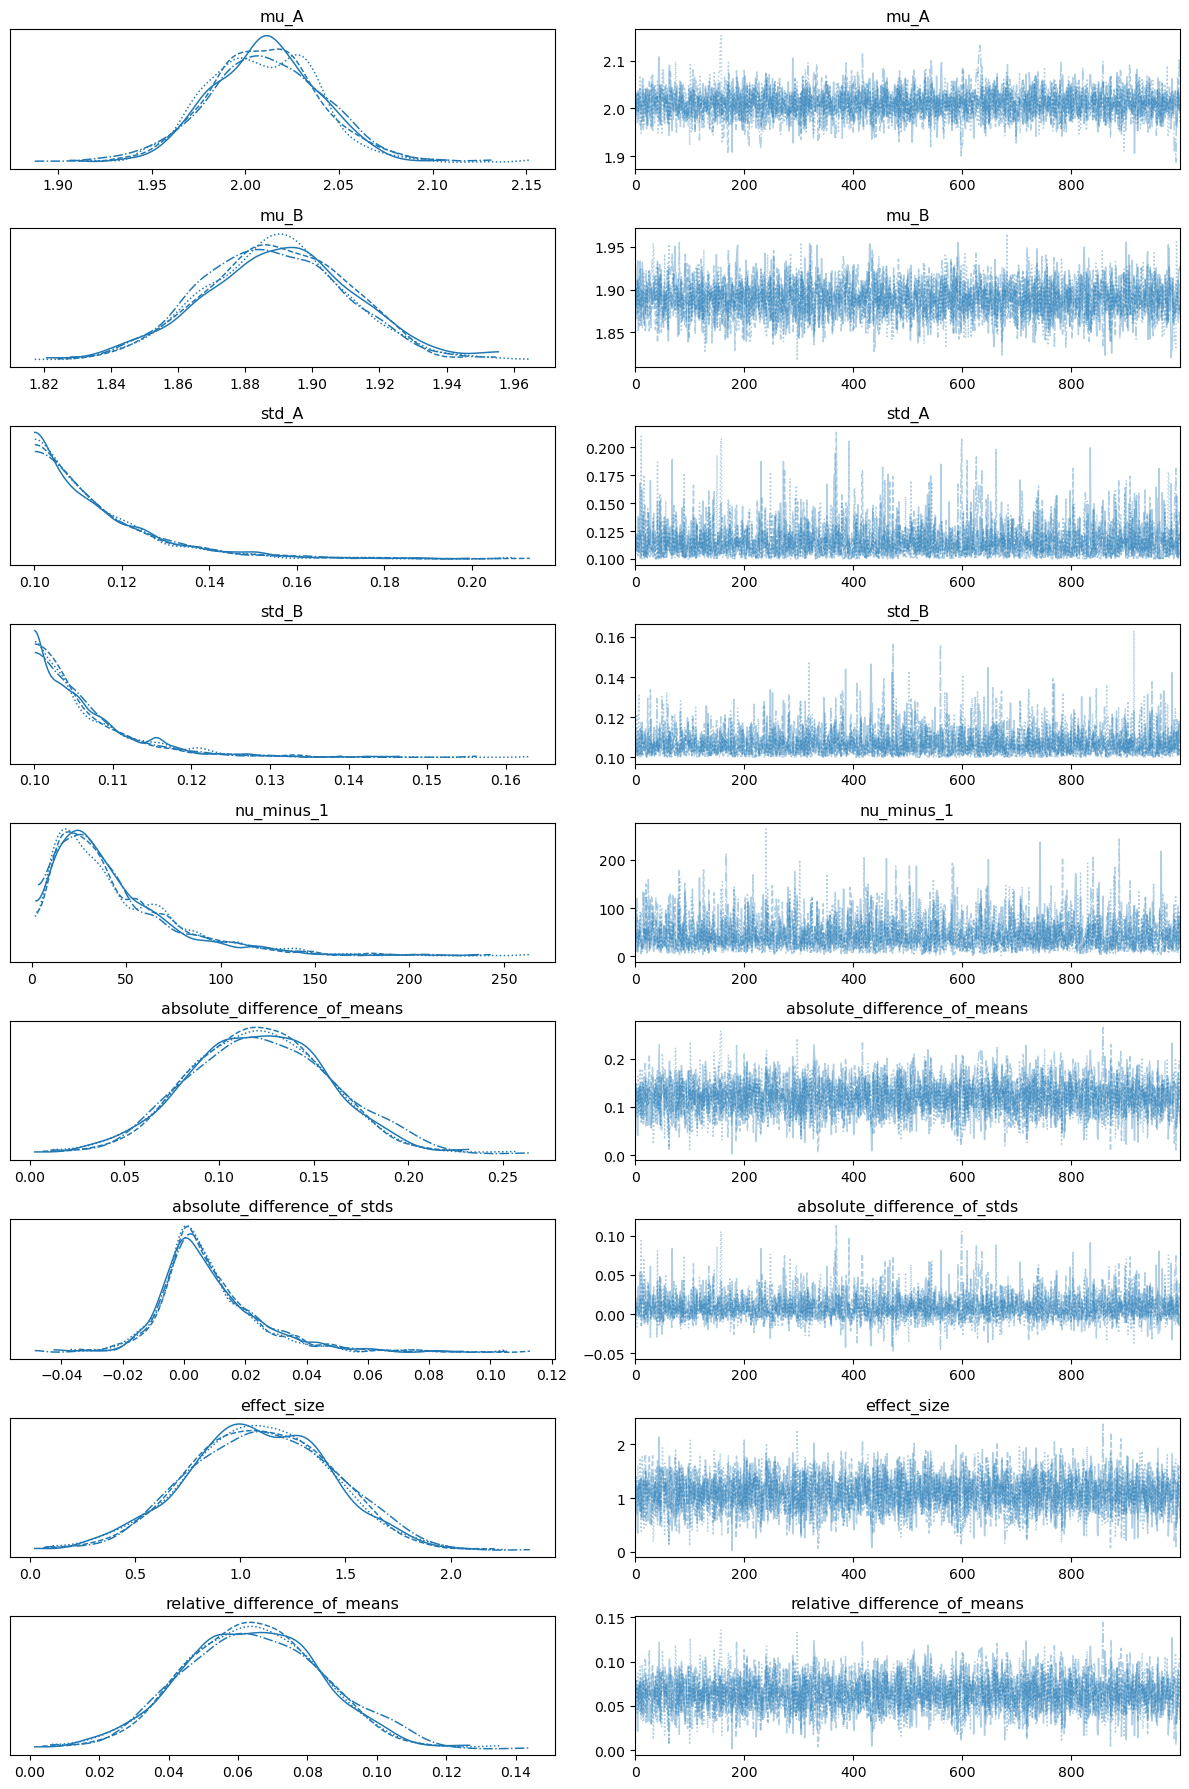

In [11]:
# analyze sampling results
# trace_plot 左側はKDE（kernel density estimation カーネル密度推定）
az.plot_trace(trace_t)
# az.plot_trace(trace_t, var_names=["mu_A", "mu_B", "std_A", "std_B", "nu_minus_1"])
plt.tight_layout();

In [12]:
# summary_plot
# az.summary(trace_t, hdi_prob=0.95)
az.summary(trace_t)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_A,2.010,0.030,1.956,2.067,0.001,0.000,3166.0,2066.0,1.0
mu_B,1.889,0.022,1.849,1.929,0.000,0.000,3010.0,2416.0,1.0
std_A,0.115,0.015,0.100,0.142,0.000,0.000,2729.0,1807.0,1.0
std_B,0.107,0.007,0.100,0.119,0.000,0.000,2581.0,1708.0,1.0
nu_minus_1,43.308,32.359,3.126,104.555,0.553,0.396,3185.0,2408.0,1.0
absolute_difference_of_means,0.121,0.037,0.055,0.191,0.001,0.000,3227.0,2435.0,1.0
absolute_difference_of_stds,0.008,0.016,-0.021,0.039,0.000,0.000,3517.0,2800.0,1.0
effect_size,1.093,0.336,0.479,1.722,0.006,0.004,3687.0,2684.0,1.0
relative_difference_of_means,0.064,0.020,0.028,0.102,0.000,0.000,3237.0,2515.0,1.0


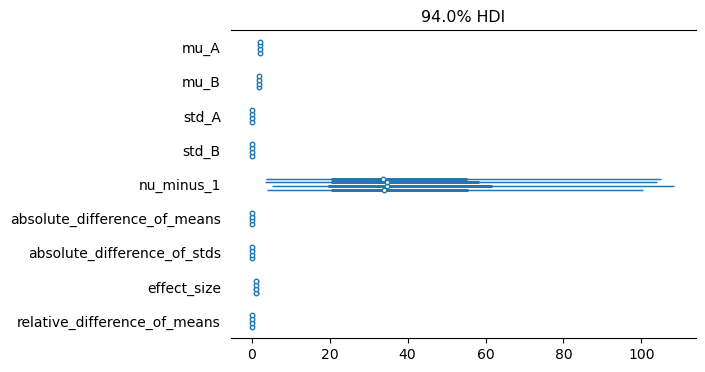

In [13]:
# foresplot
# 上のsummaryをchain別に図示化、太線は25_75percentileらしい
az.plot_forest(trace_t, # var_names=["mu_A", "mu_B", "std_A", "std_B", "nu_minus_1"],
               # r_hat=True, hdi_prob=0.8, combined=True,
               figsize=(6,4), textsize=10);

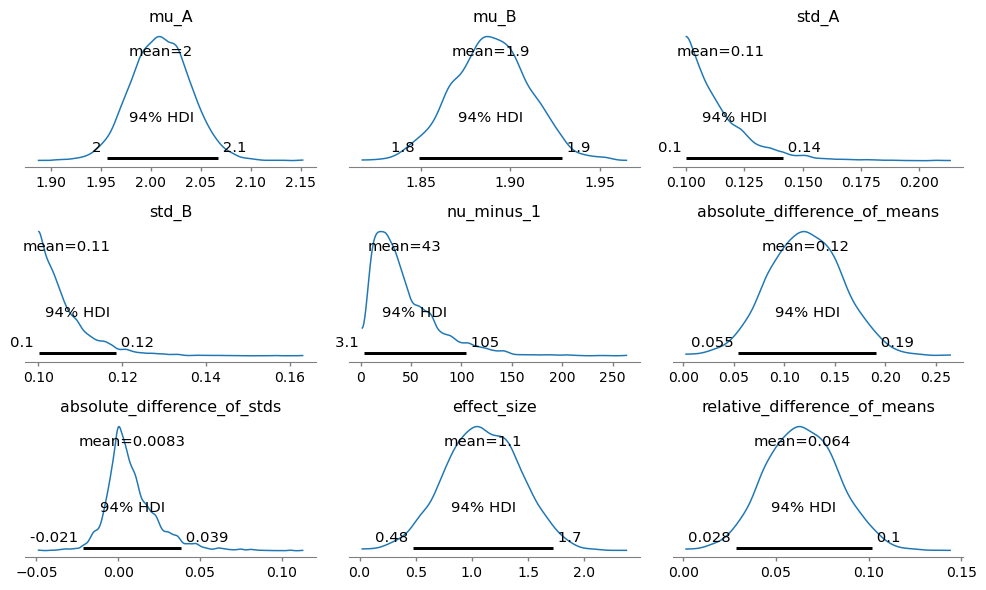

In [18]:
# posterior_samples_with_summary
az.plot_posterior(trace_t, # var_names=["mu_A", "mu_B", "std_A", "std_B", "nu_minus_1"],
                  # hdi_prob=0.95, 
                  figsize=(10,6), textsize=10)
plt.tight_layout();


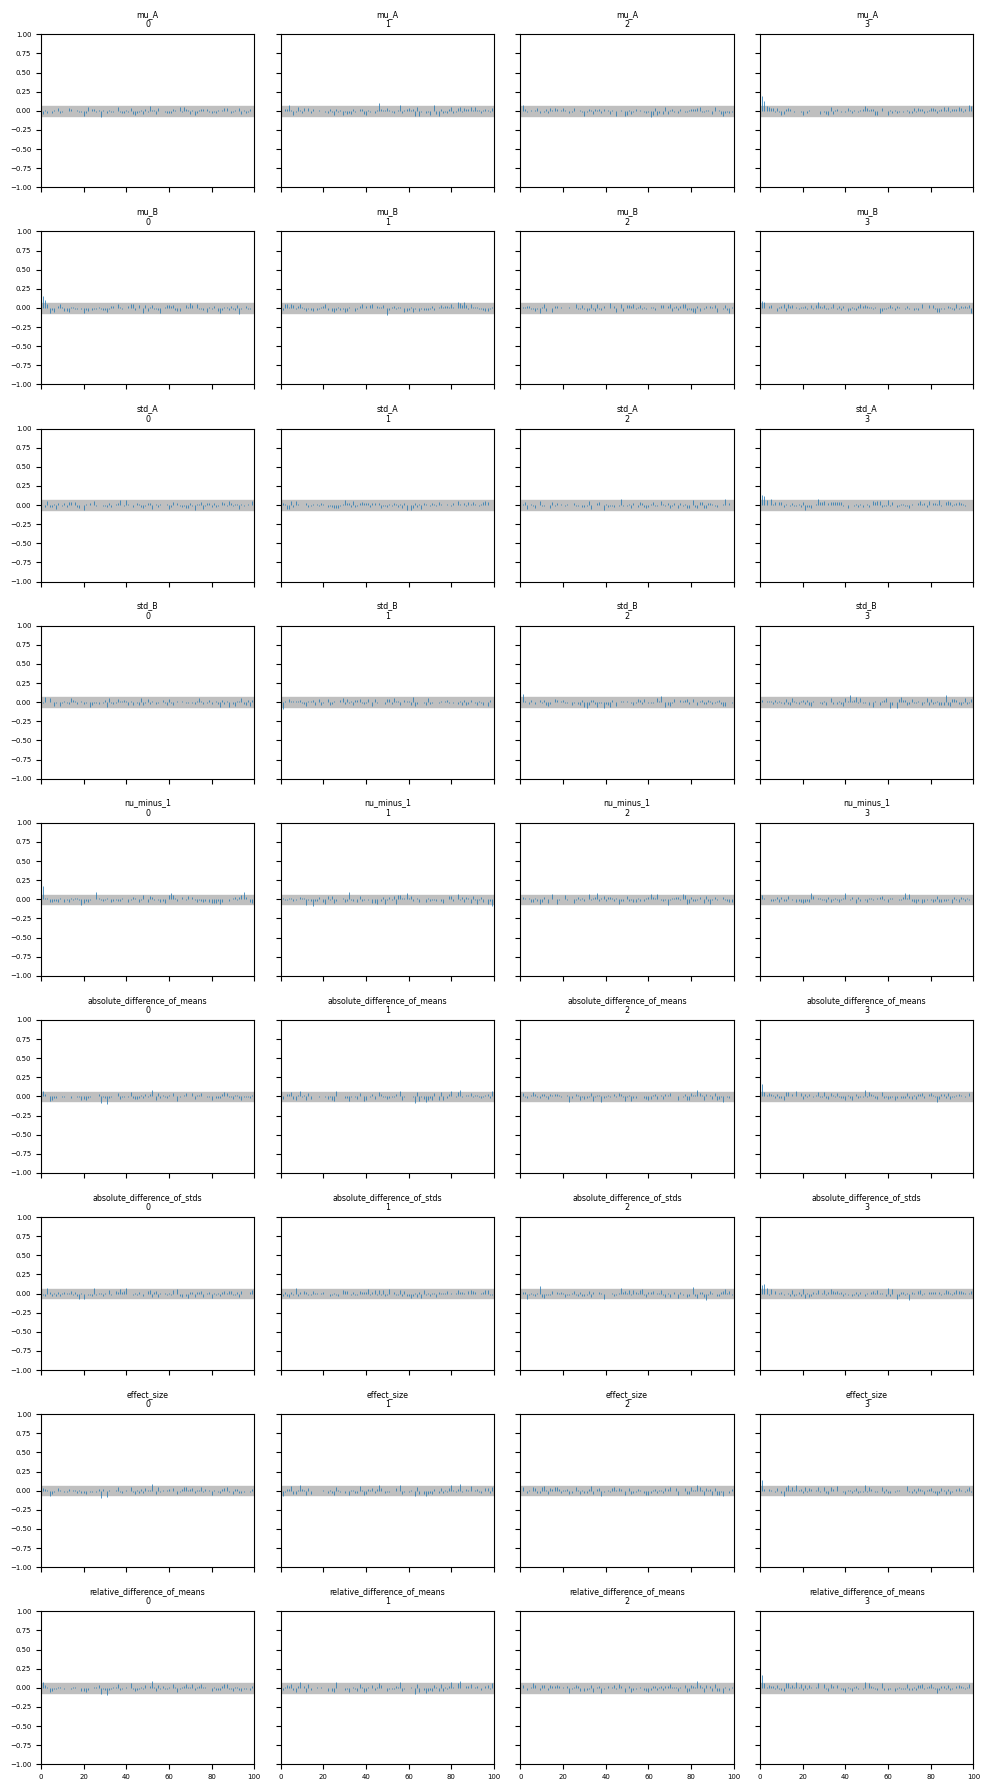

In [15]:
# 自己相関
az.plot_autocorr(trace_t, figsize=(10,18), textsize=5)
plt.tight_layout();

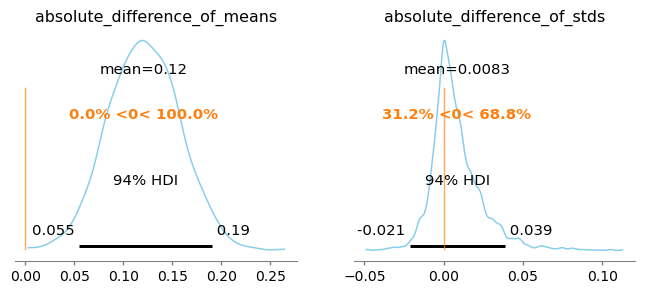

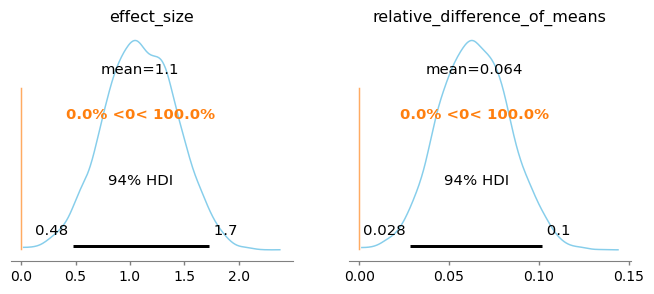

In [16]:
# posterior_samples_with_summary
# 絶対値差分と効果量のmeanやhpdの表示

az.plot_posterior(trace_t, # hdi_prob=0.95,
                 var_names=["absolute_difference_of_means", "absolute_difference_of_stds"],
                 ref_val=0, color='#87ceeb', figsize=(8,3), textsize=10);

az.plot_posterior(trace_t, # hdi_prob=0.95,
                 var_names=["effect_size", "relative_difference_of_means"],
                 ref_val=0, color='#87ceeb', figsize=(8,3), textsize=10);

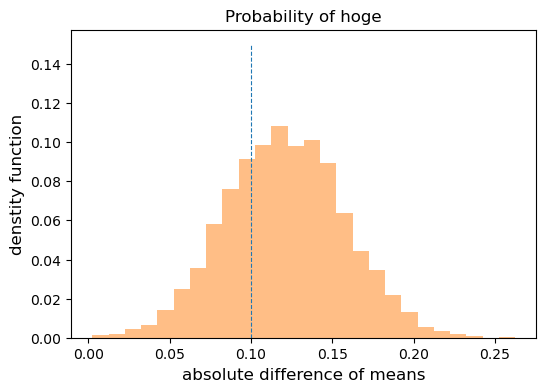

Average Probability of Increase of hoge
0.1 yen or over:70.9%


In [17]:
# 絶対値差分の事後予測分布を表示して、hoge円以上増加する確率を表示

# weights適用しない場合は、histogram自体は上のabsolute_difference_of_meansと同じhistogramになる
# ので
# 度数密度 = 度数 / 階級幅
# 相対度数密度 = 相対度数 / 階級幅
# の相対度数密度の合計を階級幅によらず1にして描画

adm_array = np.array(trace_t.posterior['absolute_difference_of_means']).reshape(-1,)  # # 多次元配列を一次元にする
# adm_array_minus = adm_array*(-1) # A<Bな結果のときは-1を掛けて逆数にする

plt.figure(figsize=(6,4))

weights = np.ones(len(adm_array)) / float(len(adm_array))

plt.hist(adm_array, bins=np.arange(adm_array.min(), adm_array.max(), 0.01), weights=weights,
         label="posterior", color='tab:orange', alpha=0.5)

plt.vlines(0.1, 0, 0.15, lw=0.8, linestyle='dashed')

plt.xlabel("absolute difference of means", fontsize=12)
plt.ylabel("denstity function", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title("Probability of hoge", fontsize=12)
plt.show()


print('Average Probability of Increase of hoge')
print('0.1 yen or over:{:.1f}%'.format((adm_array>=0.1).mean()*100))
